# Phrases Classification - Data Analysis
--- 

Challenge for the Hand Talk [selective process](https://handtalk.notion.site/Classifica-o-de-frases-por-setor-18c80adbbf874c519c9efe19678ac4c1).  
*author: [@baiochi](http://github.com/baiochi)*

# Libraries and APIs

In [1]:
# Algebra and maths operations
import numpy as np
# Data manipulation
import pandas as pd
# NLP toolkit
import nltk
# ML tools
import sklearn
# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go
# Progress bar
from tqdm import tqdm
tqdm.pandas()
# Libraries version
import session_info

# Cutom plot colors
URBAN_PALETTE_CATEGORICAL = pd.DataFrame({
    'cyan'    : '#1696d2',
    'gray'    : '#d2d2d2',
    'magenta' : '#ec008b',
    'yellow'  : '#fdbf11',
    'dark'    : '#332d2f',
    'ocean'   : '#0a4c6a',
}, index=['hex_code'])

# Colors for Cell output
WHITE = '\033[39m'
CYAN = '\033[36m'

session_info.show()

# Exploratory Data Analysis

## Data overview

In [2]:
df = pd.read_csv('data/dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  521 non-null    object
 1   category  521 non-null    object
dtypes: object(2)
memory usage: 8.3+ KB


In [3]:
df.head()

,sentence,category
0,"Auxílio-Doença Previdenciário, Benefícios em E...",orgão público
1,"PAGAR TODAS AS CONTAS EM ATRASO R$1.290,90.",finanças
2,Então encontraremos na próxima aula.,educação
3,Veja os resultados da categoria de ofertas do ...,indústrias
4,"Além disso, a embalagem é reutilizável e 100% ...","indústrias,varejo"


## Analysing Targets

### Combined labels distribution

In [4]:
px.bar(
    df['category'].value_counts(), 
    title='Value counts for each label combination'
).update_traces(
    marker_color='#1696d2', 
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=0.8
).update_layout(
    xaxis_title_text='Labels',
    yaxis_title_text='Count',
).show()

### Unique labels distribution

In [5]:
# Creating dummies
tag_counts = df['category'].str.get_dummies(sep=',')
# Create dataframe with the sum of the unique labels
label_dist = pd.DataFrame({
    'Label' : tag_counts.sum().index,
    'Count' : tag_counts.sum().values,
})
label_dist

,Label,Count
0,educação,123
1,finanças,76
2,indústrias,107
3,orgão público,155
4,varejo,106


In [6]:
px.bar(
    label_dist, 
    x='Label',
    y='Count', 
    color='Label',
    color_discrete_sequence=URBAN_PALETTE_CATEGORICAL.loc['hex_code'][:5],
    title='Labels distribuition',
    height=600,
    width=900
).update_traces(
    marker_line_color='rgb(8,48,107)',
    marker_line_width=1.5, 
    opacity=0.8
).update_xaxes(type='category').show()


### Labels correlation

In [7]:
px.imshow(tag_counts.corr(), 
    color_continuous_scale='spectral', 
    range_color=(-1,1),
    title='Label correlation Heatmap'
).update_traces(opacity=0.8).show()

## Analysing Features

### Words distribuition

In [8]:
fig = px.histogram(
    df['sentence'].apply(str.split).apply(len),
    nbins=25, 
    height=500, width=900,
    color_discrete_sequence=URBAN_PALETTE_CATEGORICAL.loc['hex_code'],
    title='Word counts in sentences'
).update_layout(
    xaxis_title_text='Number of words in a sentence',
    yaxis_title_text='Count',
)
fig.show();

### Word Cloud visualization

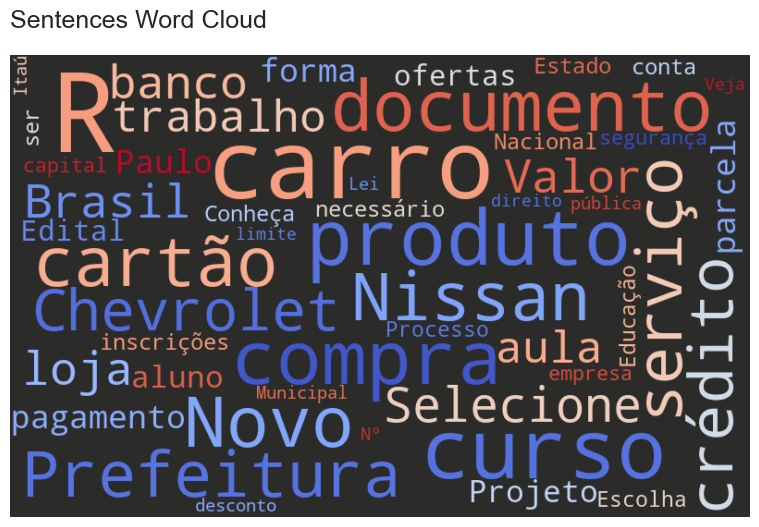

In [9]:
from wordcloud import WordCloud

# Get stop words from Portuguese
pt_stopwords = nltk.corpus.stopwords.words('portuguese')

# Get all words from the feature sentence
all_words = ' '.join(text for text in df['sentence'])

# Instance Word Cloud
word_cloud = WordCloud(
    stopwords=pt_stopwords,
    max_words=50,
    width=800, 
    height=500,
    background_color='#2b2b29',
    colormap='coolwarm',
    max_font_size = 120,
    random_state=42)

# Create Word Cloud
word_cloud.generate(all_words)

# Display image
plt.figure(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Sentences Word Cloud', size=18, pad=20, loc='left')
plt.axis('off'); plt.grid(False); plt.show()

### Pareto Chart

In [10]:
# Create Tokenizer
space_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# Generate Tokens
word_tokens = space_tokenizer.tokenize(all_words)
# Remove Stopwords
word_tokens = [word for word in word_tokens if word not in pt_stopwords]
# Calculate Tokens Frequency
word_freq = nltk.FreqDist(word_tokens)
# Create Frequency Dataframe
word_freq_df = pd.DataFrame({
    'Word' : list(word_freq.keys()),
    'Frequency' : list(word_freq.values())
})
# Get the 20 largest frequent words
most_freq_words = word_freq_df.nlargest(15, 'Frequency')
# Preview
word_freq_df.head()

,Word,Frequency
0,Auxílio-Doença,2
1,"Previdenciário,",2
2,Benefícios,5
3,Espécie,3
4,Direito,2


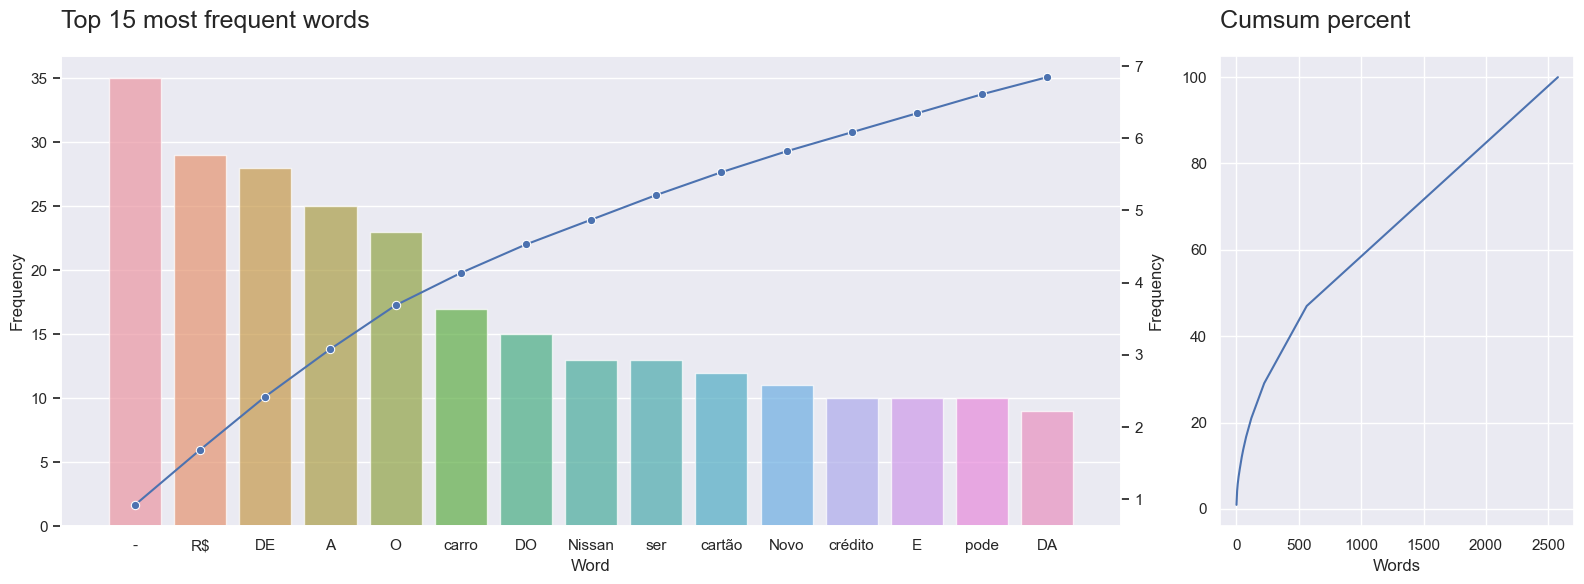

In [11]:
# Calculate cumsum percent
word_freq_df.sort_values(by='Frequency', ascending=False, inplace=True)
cum_percent = word_freq_df['Frequency'].cumsum()/word_freq_df['Frequency'].sum()*100
cum_percent.reset_index(drop=True, name='Percent', inplace=True)
# Plot Pareto Chart
fig, axis = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [3, 1]})
axis[0].set_title('Top 15 most frequent words', size=18, pad=20, loc='left')
sns.barplot(data = most_freq_words, x='Word', y='Frequency', alpha=0.7, ax=axis[0])
ax2 = axis[0].twinx()
sns.lineplot(data = cum_percent[:15], marker='o', ax=ax2)
plt.grid(False)

sns.lineplot(data = cum_percent, ax=axis[1])
axis[1].set_title('Cumsum percent', size=18, pad=20, loc='left')
axis[1].set_xlabel('Words')
axis[1].set_ylabel('')

fig.tight_layout()
plt.show()

Despite removing stopwords, words like vowels are among the most frequent ones, later we will discover how to deal with the impact of these words.

## Problem discussion

As stated on [Sklearn](https://scikit-learn.org/stable/modules/multiclass.html), the following table provides a quick reference for us to identify the problem type.  
  
| Problem type 	| Number of targets 	| Target cardinality 	| Valid type_of_target 	|
|---	|---	|---	|---	|
| Multiclass classification 	| 1 	| >2 	| ‘multiclass’ 	|
| Multilabel classification 	| >1 	| 2 (0 or 1) 	| ‘multilabel-indicator’ 	|
| Multiclass-multioutput classification 	| >1 	| >2 	| ‘multiclass-multioutput’ 	|
| Multioutput regression 	| >1 	| Continuous 	| ‘continuous-multioutput’ 	|

In summary, our data consists of 01 feature(`sentence`) and 05 targets(`category`) with binary cardinality (0 or 1), making a **Multilabel classification** problem.  

Example:  
Suposing the order of our labels is [educação, finanças, indústrias, orgão público, varejo],
for the following sentence "Além disso, a embalagem é reutilizável e 100% reciclável." matched with category "indústrias,varejo", the target output will be [0, 0, 1, 0, 1].  

For choosing our strategy, sklearn also provide a chart for selecting classifiers.  

![img](https://scikit-learn.org/stable/_images/multi_org_chart.png)

**Types of multiclass strategies:**  
- One-vs-One (OVO): fit one classifier per class pair.
- One-vs-Rest (OVR): fit one classifier per class. For each classifier, the class is fitted against all the other classes.  

**Types of multilabel strategies**  
- Multi Output: fit one classifier per target, allowing multiple target classifications .  
- Classifier Chain: combine a number of binary classifiers into a single multi-label model, accounting for correlations among targets .  
  
Note: Despite One-vs-Rest strategy falling under Multiclass classification, it can also be used for our multilabel problem if the target labels are formatted as a 2D binary matrix. This strategy can also be described as *Binary Relevance*.

`MultiOutputClassifier` and `ClassifierChain`  acts like a wrapper for our estimator to address this problem.  

# Data preprocessing

Before creating the model, we must normalize and process data in our to our estimator be able to read and compute the information.  

The workflow of the preprocessing steps is as follows:  
- **Features**
    - Remove punctuation and special characters
    - Lower casting
    - Tokezine text, i.e. create Bag fo Words
    - Remove stopwords
    - Term-frequency times Inverse ocument frequency
- **Target**
    - Binarize labels

## Tokenize and text normalization

Every step of this processing will be handle by the [**CountVectorizer**](#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) transformer.  
This method build a dictionary of features and transforms its documents into feature vectors, in other words, this method will tokenize the text and calculate the occurence of each word, thus creating our **bag of words**.  
It also accepts as parameters the other needed steps, such as removing special characters/punctuations, applying lower casting and removing stopwords.  

In [12]:
# Load portuguese stopwords with NLTK corpus
from nltk.corpus import stopwords
pt_stopwords = stopwords.words('portuguese')

from unidecode import unidecode
# Remove special characters and punctuations from stopwords
pt_stopwords_unidecoded = [unidecode(word) for word in pt_stopwords]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Instance CountVectorizer
count_vect = CountVectorizer(
    strip_accents='unicode',
    lowercase=True,
    stop_words=pt_stopwords_unidecoded
)

# Transform training data in Bag of Words
bag_of_words = count_vect.fit_transform(df['sentence'])
bag_of_words

<521x1941 sparse matrix of type '<class 'numpy.int64'>'
	with 3496 stored elements in Compressed Sparse Row format>

## Term-frequency times Inverse document frequency

With [**TfidfTransformer**](#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer), this count matrix will be normalize by a *tf* or *tf-idf* representation.  
Term-frequency inverse document-frequency(Tfid) has great use in document classification, by scaling down the impact of tokens with higher ocurrences in a given corpus, making them less informative than features with small occurences.

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer

# Instance TfidfTransformer
tfidf = TfidfTransformer()
# Fit the transformer with the matrix created by CountVectorizer
tf_transformer =tfidf.fit(bag_of_words)
# Apply to transform count-matrix in a tf-idf representation
X_transf = tf_transformer.transform(bag_of_words)
X_transf

<521x1941 sparse matrix of type '<class 'numpy.float64'>'
	with 3496 stored elements in Compressed Sparse Row format>

## Binarize target

For last, the labels also must be transformed to fit in the estimator. With [`MultiLabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer), data will be formated in a binary matrix, indicating the presence of a class label.


In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

# Instance MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Split category values
df['labels'] = df['category'].apply(str.split, sep=',')

# Fit and transform labels
y_transf = mlb.fit_transform(df['labels'])

# Create dataframe with the mbl matrix
y_transf_df = pd.DataFrame(
    y_transf,
    columns=mlb.classes_, 
    index=df.index)

y_transf_df.head()

,educação,finanças,indústrias,orgão público,varejo
0,0,0,0,1,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,1,0,0
4,0,0,1,0,1


# <hr>   

# Conclusions

Summarizing what we analyzed in this EDA:

- The data is relative small, with about 500 observations, consisting of one feature `sentence` and a multi-label `target` with 5 labels;  
- Labels is not balanced, so we must address certain strategies in the machine learning steps that takes this data imbalance into account;
- Labels aren't  correlated;
- As seem on Word Cloud and Pareto Chart, the features are likely free of outliers or noises that could introduce bia in our model.

Also, we discuss some concepts and methods on how to prepare the data in order be readable for the machine learning algorithm, like:
- Text normalization;
- Tokenizing;
- Bag of Words;
- Term-frequency times Inverse document frequency;
- Label binarization.
  
In the next notebook(`machine-learning.ipynb`), we will create models with different estimators and strategies, discuss metrics evaluations and tune hyper-parameters to increase the performance of our classifiers.  